<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI 37 Project 3

<a id='part_ii'></a>
[Part I](Part_1-Reddit_API_access_and_scraping.ipynb#part_i) <br>
[Part III](Part_3-Modelling.ipynb#part_iii)

# Part II: Cleaning and EDA

## Goals

* to be able to classify text as either 'keto' or 'paleo' with an accuracy of at least 80%
* to learn what key terms these two communities are focused on and whether we can turn them into products 
* to see if there are any other unexpected insights we can glean 

## Contents
[1. Imports (Libraries)](#imports) <br>
[2. Imports (Data)](#data_imports) <br> 
[3. Data cleaning](#data_cleaning) <br>
[4. EDA](#eda) <br>

## 1. Imports (Libraries)

<a id='imports'></a>

In [28]:
# Import basic libraries
import pandas as pd
import numpy as np


In [29]:
# Import visualisation libraries
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [30]:
# Import NLP libraries
import re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [31]:
# Import sentiment analysis libraries
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
# Import sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [33]:
# some display adjustments to account for the fact that we have many columns
# and some columns contain many characters

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 800)

## 2. Imports (Data)

<a id='data_imports'></a>

The data scraping process is outlined in ['Part I: Reddit API Access And Scraping'](Part_1-Reddit_API_access_and_scraping.ipynb#part_i). As such we will simply proceed to importing the files.

In [34]:
# Reading the raw csv files that were saved previously
keto_df = pd.read_csv('../data/keto2.csv')
paleo_df = pd.read_csv('../data/paleo2.csv')

In [35]:
keto_df.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,is_created_from_ads_ui,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,author_is_blocked,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,author_cakeday,crosspost_parent_list,url_overridden_by_dest,crosspost_parent
0,NaN,keto,"I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.\n\nIf I google “Keto without fasting” I get lots of articles about how i...",t2_9k4bjjoz5,False,NaN,0,False,Does Keto have benefits without fasting?,"[{'e': 'text', 't': 'Help'}]",r/keto,False,6,SOS,0,NaN,NaN,True,t3_14bo8pv,False,dark,1.0,NaN,public,2,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Help,False,2,NaN,False,False,self,False,NaN,[],{},NaN,True,NaN,1.687000e+09,richtext,6,NaN,NaN,text,self.keto,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt;p&gt;I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.&lt;/p&gt;\n\n&lt;p&g...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,715fe9ae-abe7-11e8-8938-0ef2dfd48a7e,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rske,False,NaN,NaN,NaN,14bo8pv,True,NaN,Irksomeone,NaN,5,True,all_ads,False,[],False,NaN,/r/keto/comments/14bo8pv/does_keto_have_benefits_without_fasting/,all_ads,False,https://www.reddit.com/r/keto/comments/14bo8pv/does_keto_have_benefits_without_fasting/,3260670,1.687000e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,keto,"Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes to making food and I made a keto meal that really hits the spot.\nMince beef (however you like it with all the seasonings onion garlic etc) browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt. About 10-15 mins in the oven. It's really good!\n\nI dont meas...",t2_axegdc92,False,NaN,0,False,Lazy keto,[],r/keto,False,6,NaN,0,NaN,NaN,True,t3_14bmpsq,False,dark,1.0,NaN,public,1,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,False,self,False,NaN,[],{},NaN,True,NaN,1.686995e+09,text,6,NaN,NaN,text,self.keto,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt;p&gt;Hi all, I&amp;#39;m back on keto after a break and I&amp;#39;m feeling good :) &lt;/p&gt;\n\n&lt;p&gt;I&amp;#39;m 

In [36]:
paleo_df.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,is_created_from_ads_ui,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,author_is_blocked,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,url_overridden_by_dest,preview,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,call_to_action,author_cakeday,poll_data,link_flair_template_id
0,NaN,Paleo,"I just can't do it, they are so tasteless",t2_mlo8iegf,False,NaN,0,False,Do you have tips to eat 1kg vegetables a day easily ?,[],r/Paleo,False,6,NaN,0,NaN,NaN,False,t3_14b6iah,False,dark,0.50,NaN,public,0,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,0,NaN,False,False,self,False,NaN,[],{},NaN,True,NaN,1.686946e+09,text,6,NaN,NaN,text,self.Paleo,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt;p&gt;I just can&amp;#39;t do it, they are so tasteless&lt;/p&gt;\n&lt;/div&gt;&lt;!-- SC_ON --&gt;",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qzzs,False,NaN,NaN,NaN,14b6iah,True,NaN,oxoUSA,NaN,19,True,all_ads,False,[],False,NaN,/r/Paleo/comments/14b6iah/do_you_have_tips_to_eat_1kg_vegetables_a_day/,all_ads,False,https://www.reddit.com/r/Paleo/comments/14b6iah/do_you_have_tips_to_eat_1kg_vegetables_a_day/,167070,1.686946e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Paleo,"I’m genuinely curious to know - are most people in this subreddit on Paleo or have you moved on? It seems like the diet is “very 2016” and hardly cracks the top diet lists anymore. \n\nFor context, I’m presently on a strict Paleo diet since it’s worked well for me in the past but I’ve considered transitioning to something that has more flexibility and variety. My suspicion is that Paleo is ove...",t2_oqhfo,False,NaN,0,False,Paleo in 2023,[],r/Paleo,False,6,NaN,0,NaN,NaN,False,t3_14ak6je,False,dark,0.83,NaN,public,12,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,12,NaN,False,False,self,False,NaN,[],{},NaN,True,NaN,1.686881e+09,text,6,NaN,NaN,text,self.Paleo,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt;p&gt;I’m genuinely curious to know - are most people in this subreddit on Paleo or have you moved on? It seems like the diet is “very 2016” and hardly cracks the top diet lists anymore. &lt;/p&gt;\n\n&lt;p&gt;For context, I’m presently on a strict Paleo diet since it’s worked well for me in the past but I’ve considered transitioning to something t...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qzzs,False,NaN,NaN,NaN,14ak6je,True,NaN,Cheffreyy,NaN,37,True,all_ads,False,[],False,NaN,/r/Paleo/comments/14ak6je/paleo_in_2023/,all_ads,False,https://www.reddit.com/r/Paleo/comments/14ak6je/paleo_in_2023/,167070,1.686881

In [37]:
# checking that both dataframes contain approximately the same number of rows/posts
print(keto_df.shape)
print(paleo_df.shape)

(976, 113)
(929, 118)


## 3. Data Cleaning

<a id='data_cleaning'></a>

First, we will save the relevant columns in new dataframes. As our business case only requires us to analyse the actual text messages posted by future clientele, we will not be needing other fields that are scrapped from the subreddits. After reviewing the first few rows of our scrapped data, we will only need the `title` and `selftext` for analysis.  The `y` outcome on whether the subreddit is Paleo or Keto is found in `subreddit`. 

In [38]:
# saving the relevant columns into new dataframes (df)
keto = keto_df[['subreddit', 'title', 'selftext']]
paleo = paleo_df[['subreddit', 'title', 'selftext']]

In [39]:
# combining the two dfs as one
ketopaleo = pd.concat([keto, paleo], axis=0).reset_index(drop=True)

In [40]:
# checking our new combined df: there are 1,905 rows in total and the columns are all string variables.
print(ketopaleo.shape)
display(ketopaleo.head(2))
display(ketopaleo.tail(2))
print(ketopaleo.dtypes)

(1905, 3)


,subreddit,title,selftext
0,keto,Does Keto have benefits without fasting?,"I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.\n\nIf I google “Keto without fasting” I get lots of articles about how i..."
1,keto,Lazy keto,"Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes to making food and I made a keto meal that really hits the spot.\nMince beef (however you like it with all the seasonings onion garlic etc) browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt. About 10-15 mins in the oven. It's really good!\n\nI dont meas..."


,subreddit,title,selftext
1903,Paleo,Need help reaching 3200 calories a day,"I just starting going back to the gym after a break for health issues. I have calculated my calorie requirement to be about 3200 calories, or actually 13,750 kj since my country uses metric.\n\nI am on a high protein and fat, low/adequate carb, diet and finding it hard to hit that calorie target.\n\nFor reference, breakfast is bacon, eggs, mushrooms and haloumi; lunch is a sandwich or two; and..."
1904,Paleo,How to get magnesium,Anyone had success with getting enough magnesium without Nuts and Seeds?


subreddit    object
title        object
selftext     object
dtype: object


In [41]:
# for clarity, we will relabel the 'reddit' column to 'redditlabel'
ketopaleo.columns = ['redditlabel', 'title', 'selftext']

#### Treatment of nan values

We also checked for nan values. There are a total of 293 nan values in the `selftext` column, of which 291 belong to `Paleo` and 2 belong to `Keto`. We did a quick scan on the websites, and found that most of these are due to posts with images and no words, or posts with titles alone and no words or images in the text body at all. We recognise that this seems particularly more common in Paleo, as Paleo subreddit users tend to share the pictures of their food or meal prep. Since these posts still contain a post title, we have decided to merge both `title` and `selftext` as one for further analysis.

Examples to illustrate the above point: 

<img src='../images/examples.png' alt="examples" align='left' width='800px'>

In [42]:
# there are 293 nan values in 'selftext'
ketopaleo.isna().sum()

redditlabel      0
title            0
selftext       293
dtype: int64

In [43]:
# upon further investigation, and double checking on the websites, 
# most of these are from Paleo subreddit.
ketopaleo.groupby('redditlabel')['selftext'].apply(lambda x: x.isna().sum())


redditlabel
Paleo    291
keto       2
Name: selftext, dtype: int64

In [44]:
# we will fill these na with '', followed by combining selftext and title columns
ketopaleo.fillna('', inplace=True)
ketopaleo.isna().sum()

redditlabel    0
title          0
selftext       0
dtype: int64

In [45]:
ketopaleo['titletext'] = ketopaleo['title'] + ' ' + ketopaleo['selftext']

Next, we create our target variable. 'keto' as 0 and 'Paleo' as 1.

In [46]:
# Mapping 'keto' to 0 and 'paleo' to 1
ketopaleo['redditlabel'] = ketopaleo['redditlabel'].map({'keto':0,
                                                        'Paleo':1})

In [47]:
# Rechecking dataframe that the redditlabels have been mapped. 
ketopaleo.head(2)

,redditlabel,title,selftext,titletext
0,0,Does Keto have benefits without fasting?,"I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.\n\nIf I google “Keto without fasting” I get lots of articles about how i...","Does Keto have benefits without fasting? I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.\n\nIf I google “Keto without fa..."
1,0,Lazy keto,"Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes to making food and I made a keto meal that really hits the spot.\nMince beef (however you like it with all the seasonings onion garlic etc) browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt. About 10-15 mins in the oven. It's really good!\n\nI dont meas...","Lazy keto Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes to making food and I made a keto meal that really hits the spot.\nMince beef (however you like it with all the seasonings onion garlic etc) browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt. About 10-15 mins in the oven. It's really good!\n\nI..."


Before moving on to further analysis, we performed a basic clean on the `titletext` feature. For the cleaning step, we will convert text to lowercase, remove punctuations, and remove other unnecessary strings such as those containing http. 

In [48]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove r/
    text = text.replace('r/', '')
    # Remove &amp; 
    text = text.replace('&amp;', '')
    # Remove \n
    text = text.replace('\n', ' ')
    # Remove strings that contain http
    text = re.sub(r'\S*http\S*', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove non-Roman characters
    text = re.sub('([^\x00-\x7F])+', ' ', text)
    # Remove chunks of empty spaces
    text = text.replace('\s+', ' ')
    # Remove 'nan'
    text = text.replace('nan', ' ')

    return text

# creating a new column for the cleaned text
ketopaleo['text_clean'] = ketopaleo['titletext'].map(lambda x: clean_text(x))


## 4. EDA 

<a id='eda'></a>

In this section, we process the data further to gain more insights. 

As this section is fairly extensive, it has been broken down further into 

### Contents - EDA
[A. Word And Character Count](#word_char)<br>
[B. Tokenising, Lemmatising, And Removal of Stop Words](#tok_lem_stop)<br>
[C. Sentiment Analysis](#sentiment)<br>
[D. Unigrams](#unigram)<br>
[E. Bigrams](#bigram)<br>
[F. Trigrams](#trigram)<br>
[G. Common Words](#common)<br>

### A. Word and Character Count

<a id='word_char'></a>

To better understand the nature of both subreddits in terms of the length of posts as well as choice of words used, we decided to create 2 new columns: `char_count`, that measures the total character count in a post, and `word_count`, that mesaures the total world count of posts.

In [49]:
# Creating a new column 'char_count'
ketopaleo['char_count'] = ketopaleo['text_clean'].map(len)

# Creating new column 'word_count'
ketopaleo['word_count'] = ketopaleo['text_clean'].map(lambda x: len(x.split()))

In [50]:
ketopaleo.head()

,redditlabel,title,selftext,titletext,text_clean,char_count,word_count
0,0,Does Keto have benefits without fasting?,"I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.\n\nIf I google “Keto without fasting” I get lots of articles about how i...","Does Keto have benefits without fasting? I enjoy how I feel when I’m consistent with a Keto style diet, but I don’t enjoy fasting. All the keto information appears to be very much in support of fasts, with a lot of emphasis on how it increases the benefits. I’m starting to feel that without it I can’t reach my health goals and no one seems to do Keto without it.\n\nIf I google “Keto without fa...",does keto have benefits without fasting i enjoy how i feel when i m consistent with a keto style diet but i don t enjoy fasting all the keto information appears to be very much in support of fasts with a lot of emphasis on how it increases the benefits i m starting to feel that without it i can t reach my health goals and no one seems to do keto without it if i google keto without fasting i...,972,196
1,0,Lazy keto,"Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes to making food and I made a keto meal that really hits the spot.\nMince beef (however you like it with all the seasonings onion garlic etc) browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt. About 10-15 mins in the oven. It's really good!\n\nI dont meas...","Lazy keto Hi all, I'm back on keto after a break and I'm feeling good :) \n\nI'm super lazy when it comes to making food and I made a keto meal that really hits the spot.\nMince beef (however you like it with all the seasonings onion garlic etc) browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt. About 10-15 mins in the oven. It's really good!\n\nI...",lazy keto hi all im back on keto after a break and im feeling good im super lazy when it comes to making food and i made a keto meal that really hits the spot mince beef however you like it with all the seasonings onion garlic etc browned off then thrown in the oven with some dollops of cream cheese and cheddar on top to melt about 1015 mins in the oven its really good i dont measure thing...,433,87
2,0,What are your favorite dairy free meals or snacks?,"I would like to make dairy free Keto meals that my wife can eat, she is not in Keto, but would like her to have the option to eat it. We have a 4 month old that when my wife eats dairy, they baby has terrible stomach pain.","What are your favorite dairy free meals or snacks? I would like to make dairy free Keto meals that my wife can eat, she is not in Keto, but would like her to have the option to eat it. We have a 4 month old that when my wife eats dairy, they baby has terrible stomach pain.",what are your favorite dairy free meals or snacks i would like to make dairy free keto meals that my wife can eat she is not in keto but would like her to have the option to eat it we have a 4 month old that when my wife eats dairy they baby has terrible stomach pain,267,57
3,0,Blurred Vision,"I did low carb / keto for about 2 years and fell off the wagon. I at better than my carby days, but not at all great.\n\nI'm type 2 diabetic\n\nI started again a week ago, and while lots of things are in check (frequent urination - gone, skin problems - gone, sore feet - gone, and down 3KG), am suffering from blurry vision.\n\nA google search says its rare, and caused from dropping blood sugar...","Blurred Vision I did low carb / keto for about 2 years and fell off the wagon. I at better than my carby days, but not at all great.\n\nI'm type 2 diabetic\n\nI started again a week ago, and while lots

In [51]:
ketopaleo['word_count'].sum()

214201

In [52]:
# Finding posts with the longest and shortest word counts
display(ketopaleo.sort_values(by='word_count', ascending=True)[['text_clean', 'redditlabel']].head())

display(ketopaleo.sort_values(by='word_count', ascending=False)[['text_clean','redditlabel']].head())

,text_clean,redditlabel
1827,delicious,1
1247,spectrovenator,1
1557,um,1
1140,sweets,1
1220,taubatherium,1


,text_clean,redditlabel
1415,practical guide for going paleo from sad a guide on transitioning from being an extremely picky eater who only eats fast food for every meal to being fullon paleo as someone who grew up loving mostly processed foods i thought i would never be able to change my diet these were my comfort foods and my lifestyle people would say to stop drinking soda and eat well and i d hear them and i d want t...,1
817,advice and clarification in regards to keto related topics hello everyone thought i would ask the community something that has had me thinking as im going back to another round of keto so not too much of a stranger to it know the concept of it and such and had some various success with it and mostly other reasons that hindered my continued progress for more context a recent checkup shows ...,0
247,for the first time in my life im getting better thanks to keto okay ive been around reddit for a decade finally joined 7 years ago have so much anxiety about posting that i only have 70 karma id promise im not a troll but isnt that what trolls do anxiety be damned the results im seeing from keto are so life changing that i feel compelled to post if it helps another person in my position this i...,0
1798,intermittent fasting and autophagy what is autophagy humanity has longed for the desire of eternal youth for centuries our body is able to renew itself or more precisely its own cells in a completely natural way this process is called autophagy or autophagocytosis and means from the latin translated auto itself and from the greek phagein to digest the 2016 nobel prize in medicine was ...,1
823,a month of ketosis resulting in 99kg 218 lbs of weight loss today is the end of my first month on keto and it s been a fairly successful month 28 days so i thought i d share what i ve done and the process\r \r male 48 years old 194 cm starting weight 122 kg 269 lbs current weight 1121 kg 2471 lbs which is a loss of 990kg 218 lbs\r \r this isn t my first time on the keto diet and i cons...,0


In both plots below, we see that both distributions are skewed to the right, which implies that the majority of posts for both Keto and Paleo tend to be shorter. 

`keto` posts are consistently longer in terms of both the number of characters and number of words. Based on the median `word_count` for keto, keto posts are about 2.5x lengthier than paleo posts. 

summary of keto word_count:


count     976.000000
mean      144.168033
std       125.374747
min         6.000000
25%        73.750000
50%       109.000000
75%       171.000000
max      1489.000000
Name: word_count, dtype: float64

summary of paleo word_count:


count     929.000000
mean       79.109795
std       111.830926
min         1.000000
25%        16.000000
50%        45.000000
75%        94.000000
max      1662.000000
Name: word_count, dtype: float64

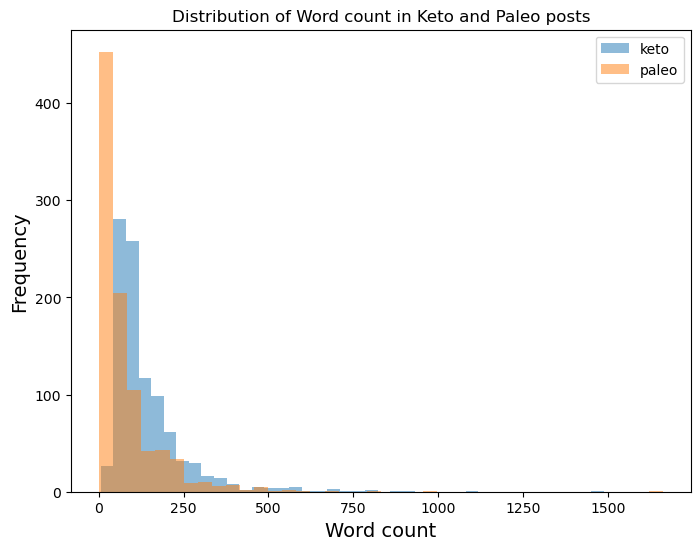

In [53]:
# Distribution of word count
plt.figure(figsize=(8,6))
plt.hist(ketopaleo[ketopaleo['redditlabel'] == 0]['word_count'], bins=40, alpha=0.5, label='keto')
plt.hist(ketopaleo[ketopaleo['redditlabel'] == 1]['word_count'], bins=40, alpha=0.5, label='paleo')
plt.grid(False)
plt.xlabel('Word count', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Word count in Keto and Paleo posts')
plt.legend(loc='upper right')

# Summary info
print('summary of keto word_count:')
display(ketopaleo[ketopaleo['redditlabel']==0]['word_count'].describe())

print('summary of paleo word_count:')
display(ketopaleo[ketopaleo['redditlabel']==1]['word_count'].describe())

summary of keto char_count:


count     976.000000
mean      747.932377
std       659.240881
min        34.000000
25%       376.500000
50%       558.500000
75%       890.500000
max      8234.000000
Name: char_count, dtype: float64

summary of paleo char_count:


count     929.000000
mean      424.405813
std       604.596991
min         4.000000
25%        90.000000
50%       231.000000
75%       494.000000
max      8655.000000
Name: char_count, dtype: float64

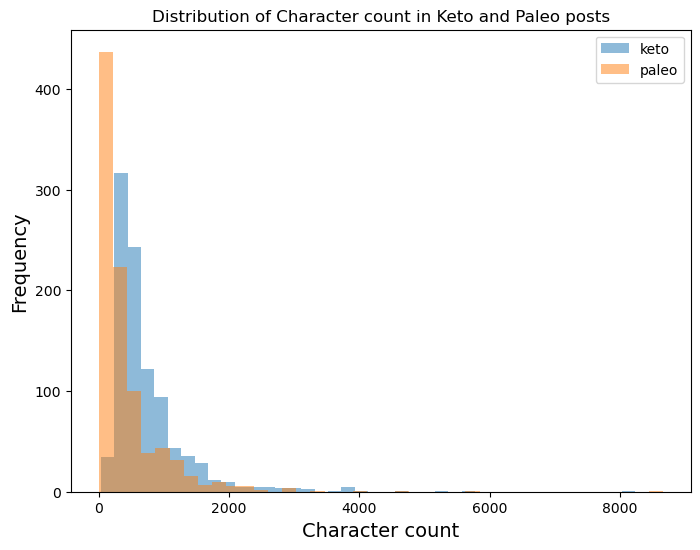

In [54]:
# Distribution of char count
plt.figure(figsize=(8,6))
plt.hist(ketopaleo[ketopaleo['redditlabel'] == 0]['char_count'], bins=40, alpha=0.5, label='keto')
plt.hist(ketopaleo[ketopaleo['redditlabel'] == 1]['char_count'], bins=40, alpha=0.5, label='paleo')
plt.grid(False)
plt.xlabel('Character count', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Character count in Keto and Paleo posts')
plt.legend(loc='upper right')

# Summary info
print('summary of keto char_count:')
display(ketopaleo[ketopaleo['redditlabel']==0]['char_count'].describe())

print('summary of paleo char_count:')
display(ketopaleo[ketopaleo['redditlabel']==1]['char_count'].describe())

### B. Tokenising, Lemmatising, And Removal of Stop Words

<a id='tok_lem_stop'></a>

In order to analyse the column `titletext`, we need to complete some pre-processing steps.

We will do three major processes: 
#### Tokenising
This is the process of breaking the text down into word chunks. In our case, we will break them into chunks of 1, 2, 3, and 4 words to see if any interesting patterns emerge. These will also be referred to as 'n-grams' where n is 1, 2, 3, or 4. 

#### Lemmatisation/Stemming
The process of simplifying words. After initial studies, we concluded that Lemmatisation (the act of grouping words based on positional arguments) performed better than Stemming. We have excluded the results post-stemming from this notebook. 

#### Removal of stopwords
The process of removing common words to reduce noise.

In [63]:
# first we import a body of already defined stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [64]:
# note: these additional stopwords are the result of earlier analysis.
# we found that these appeared in the top 20 words and contributed noise
# hence we added them to the list of stopwords to remove them and reduce the overfitting of the model

extrawords = ['pinned','top','subreddit','ask','question','ha','beginner','hello',
              'talk','wa','also','ive','im','use','community', 'want','would','think','really', 'nutshell', 'utshell', 'support','thread']
stopwords.extend(extrawords)

In [65]:
# function to remove stopwords 
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

# Apply the function to the 'lemma_text' column
ketopaleo['text_lemma'] = ketopaleo['text_lemma'].apply(remove_stopwords)

In [66]:
# custom function for plotting top n grams

def top_n_grams(corpus, n=20, ngram=(1,1), stop=None):
    # Create a CountVectorizer object with specified n-gram range and stop words
    vec = CountVectorizer(ngram_range=ngram, stop_words=stop)
    # Convert the corpus into a bag of words representation
    bag_of_words = vec.fit_transform(corpus)
    # Calculate the sum of words across all documents
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of (word, count) pairs from the vocabulary and word counts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list of (word, count) pairs by count in descending order and select top n
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    # Store top n common n-grams in a dataframe
    df = pd.DataFrame(words_freq, columns=['text', 'count'])
    # Sort the dataframe by the count column in descending order
    df = df.sort_values(by='count', ascending=False)

    return df 

In [67]:
# custom function for lemmatizing

wn = WordNetLemmatizer()
tok = word_tokenize

def get_wordnet_pos(word):
    """ Map POS tag to first character lemmatize() accepts """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatizing(text):
    # Tokenize the text into words
    tokens_words = tok(text)
    
    # Lemmatize each word and store the lemmatized output in a list
    output = [wn.lemmatize(word, get_wordnet_pos(word)) for word in tokens_words]
    
    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(output)
    
    return lemmatized_text

ketopaleo['text_lemma'] = ketopaleo['text_clean'].apply(lemmatizing)

This sample shows the impact of the lemmatisation process on the text:

In [68]:
ketopaleo[['text_clean', 'text_lemma']].sample(2)

,text_clean,text_lemma
224,20230609 weekend victory lap have you had a personal victory this week share it with us hello keto community youve all been working so hard and we love hearing about all of your personal victories clothes too big friends and family noticing a difference skipped over something unhealthy please use this thread to share any of your scale or nonscale victories with us make sure to give us some...,20230609 weekend victory lap have you have a personal victory this week share it with u hello keto community youve all be work so hard and we love hearing about all of your personal victory clothes too big friend and family notice a difference skip over something unhealthy please use this thread to share any of your scale or nonscale victory with u make sure to give u some background what brou...
674,keto chicken chips cooked chicken i used rotisserie chicken sour cream gratedcrumbled cheese garlic mix together and fashion into a chip shape roll in crushed pork crackles i cooked them in the airfryer on 180 degrees celsius for 8 minutes leave them sit for a few minutes so the cheese isnt runny gently get out using a slidenot tongs,keto chicken chip cooked chicken i use rotisserie chicken sour cream gratedcrumbled cheese garlic mix together and fashion into a chip shape roll in crush pork crackle i cooked them in the airfryer on 180 degree celsius for 8 minute leave them sit for a few minute so the cheese isnt runny gently get out use a slidenot tongs


The example statement below shows that the lemmatization now takes care of both noun and non-noun words.

In [69]:
# example: been --> be, losing --> lose, started --> start.
lemmatizing('i havent been losing weight since i started keto')

'i havent be lose weight since i start keto'

Now that we are done with pre-processing, we can now export this dataframe for analysis in Part III. 

In [70]:
# export this dataframe for use in Part III: Modelling
pd.DataFrame(ketopaleo).to_csv('../data/combined.csv', index = False)

### C. Sentiment Analysis

<a id='sentiment'></a>

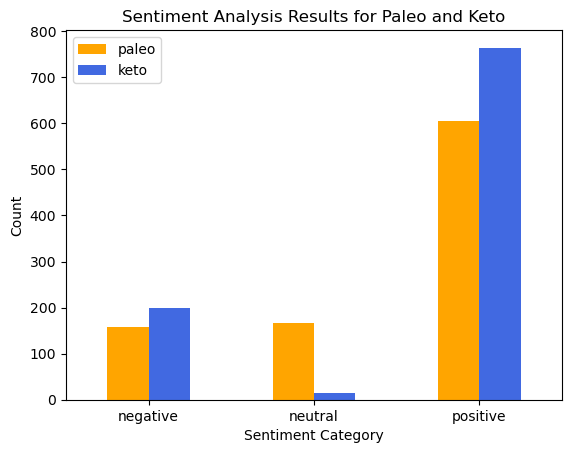

In [71]:
def get_sentiment(text):
    # create TextBlob object of passed text 
    analysis = TextBlob(text) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

ketopaleo['sentiment'] = ketopaleo['text_lemma'].apply(get_sentiment)

paleo_sentiment_counts = ketopaleo[ketopaleo['redditlabel'] == 1]['sentiment'].value_counts()
keto_sentiment_counts = ketopaleo[ketopaleo['redditlabel']== 0]['sentiment'].value_counts()

# Define the sentiment categories in the desired order
sentiment_categories = ['negative', 'neutral', 'positive']

# Create a DataFrame to hold the sentiment counts for both subgroups
combined_sentiment_counts = pd.DataFrame({
    'paleo': paleo_sentiment_counts.reindex(sentiment_categories, fill_value=0),
    'keto': keto_sentiment_counts.reindex(sentiment_categories, fill_value=0)
})

# Create a grouped bar plot with custom colors and category order
combined_sentiment_counts = combined_sentiment_counts.reindex(sentiment_categories)
combined_sentiment_counts.plot(kind='bar', color=['orange', 'royalblue'])

# Customize the plot
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results for Paleo and Keto')
plt.xticks(rotation=0)
plt.legend


# Show the plot
plt.show()

### D. Unigrams

<a id='unigram'></a>

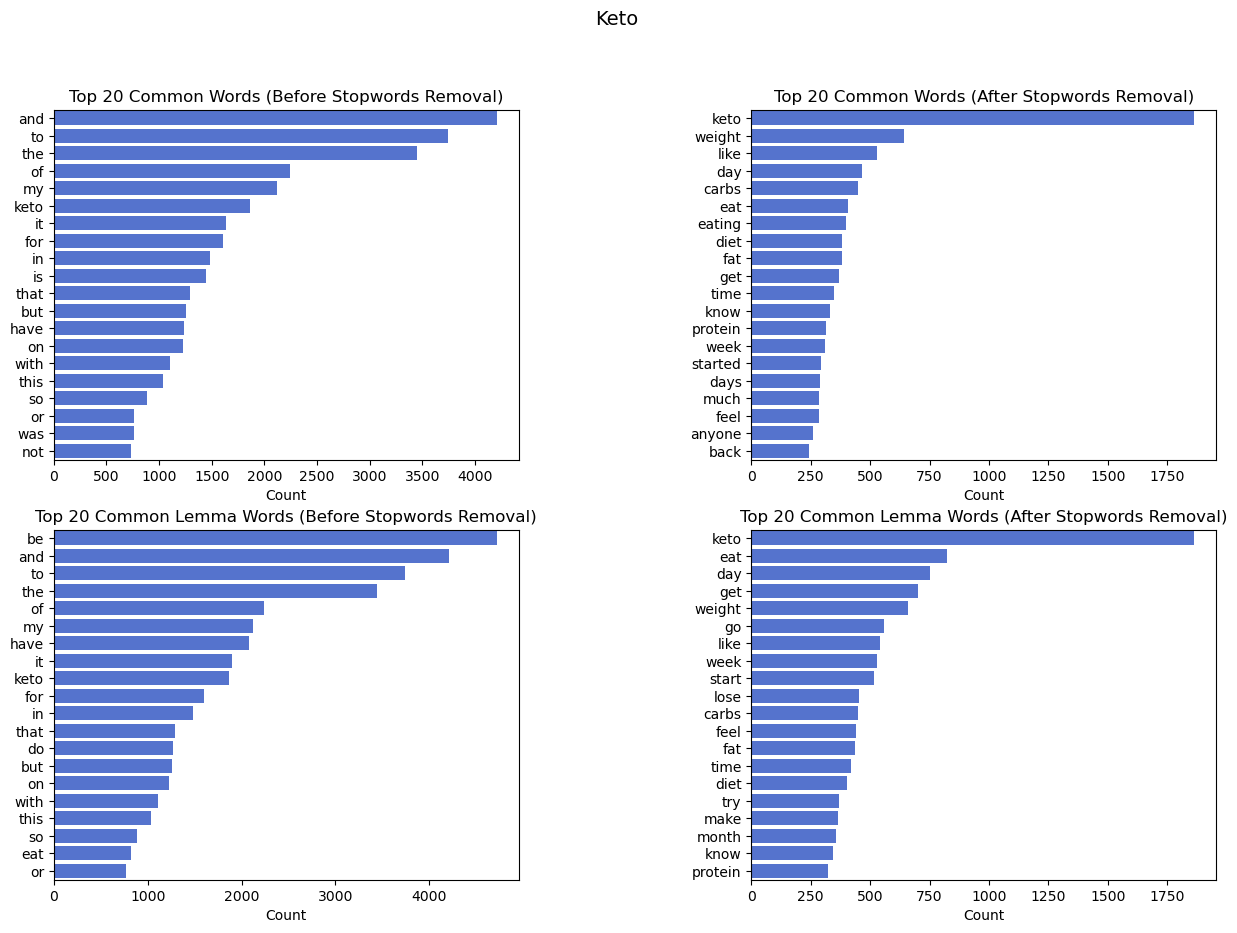

In [77]:
# plotting top unigrams for Keto (4 types for comparison)

df1clean = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_clean'], n=20, ngram=(1, 1), stop=None)
df1clean_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_clean'], n=20, ngram=(1, 1), stop=stopwords)
df1lemma = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_lemma'], n=20, ngram=(1, 1), stop=None)
df1lemma_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_lemma'], n=20, ngram=(1, 1), stop=stopwords)


# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top common words before removing stop words
sns.barplot(data=df1clean, y='text', x='count', color='royalblue', ax=axes[0,0])
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel('Count')
axes[0,0].set_title('Top 20 Common Words (Before Stopwords Removal)')

# Plot the top common words after removing stop words
sns.barplot(data=df1clean_stop, y='text', x='count', color='royalblue', ax=axes[0,1])
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Count')
axes[0,1].set_title('Top 20 Common Words (After Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df1lemma, y='text', x='count', color='royalblue', ax=axes[1,0])
axes[1,0].set_ylabel(None)
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Top 20 Common Lemma Words (Before Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df1lemma_stop, y='text', x='count', color='royalblue', ax=axes[1,1])
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Count')
axes[1,1].set_title('Top 20 Common Lemma Words (After Stopwords Removal)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.5)

# Add an overall title for all four plots
fig.suptitle('Keto', fontsize=14)

# Show the plot
plt.show()

#### Insights:
Apart from `eat` and name of the `diet`, key terms for `keto` included macronutrients$^1$ (i.e. `carbs`, `fat`, `protein`), `lose` `weight`, and an element of time (i.e. `day`, `week`, `month`). 

#### Impact of stopwords removal:
The removal of stopwords was crucial to highlight these above terms, as the words reflected before stopwords removal had a lot of noise (in the scale of thousands). We also see this in the other plots below, regardless of the n-gram range. Thus, moving forward, we will only interpret plots with stopwords removed.

#### Impact of lemmatization:
We also noticed that `protein` was removed from the top 20 after lemmatization. This is due to the lemmatizing process which has made other non-noun words such as `want` (but meaningless to us) more prominent. Since `want` is meaningless to us, we have included it in the stopwords so that `protein` now appears, as shown above. Nevertheless, lemmatization has also helped to surface `month`, and confirms the whole spectrum of the time element that is commonly found in keto posts. This is important as it shows that those on the keto diet have been following the diet in different durations, or that they have been practising it on a time-limited basis. 


<sup>1. Macronutrients are the nutrients we need in larger quantities that provide us with energy: in other words, fat, protein and carbohydrate. Micronutrients are mostly vitamins and minerals, and are equally important but consumed in very small amounts. We generally get our micronutrients along with macronutrients. 
Source: [British Heart Foundation](https://www.bhf.org.uk/informationsupport/heart-matters-magazine/nutrition/ask-the-expert/macronutrients#:~:text=Macronutrients%20are%20the%20nutrients%20we,our%20micronutrients%20along%20with%20macronutrients![image.png](attachment:image.png))</sup>

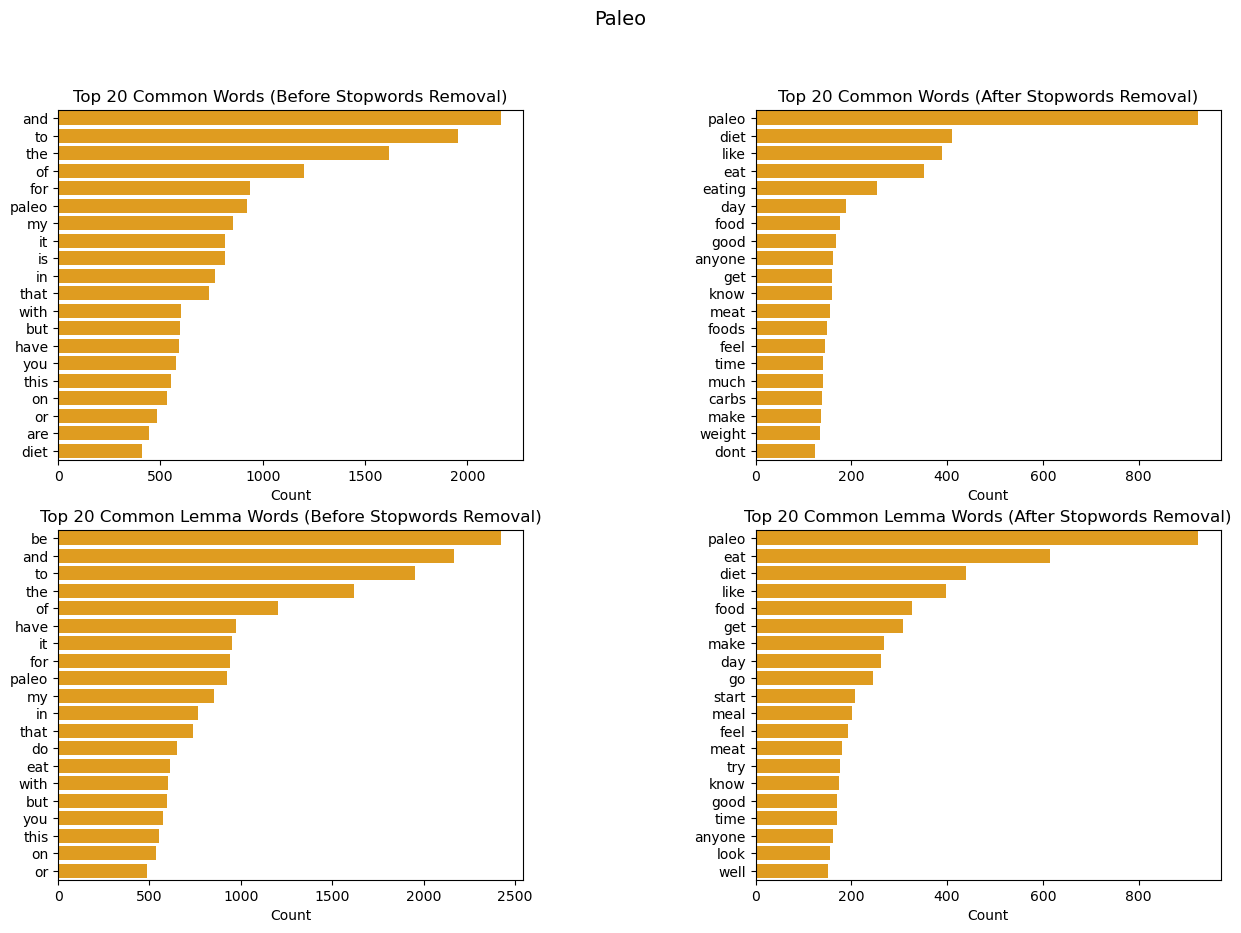

In [82]:
# plotting top unigrams for Paleo

df2clean = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_clean'], n=20, ngram=(1, 1), stop=None)
df2clean_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_clean'], n=20, ngram=(1, 1), stop=stopwords)
df2lemma = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_lemma'], n=20, ngram=(1, 1), stop=None)
df2lemma_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_lemma'], n=20, ngram=(1, 1), stop=stopwords)


# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top common words before removing stop words
sns.barplot(data=df2clean, y='text', x='count', color='orange', ax=axes[0,0])
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel('Count')
axes[0,0].set_title('Top 20 Common Words (Before Stopwords Removal)')

# Plot the top common words after removing stop words
sns.barplot(data=df2clean_stop, y='text', x='count', color='orange', ax=axes[0,1])
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Count')
axes[0,1].set_title('Top 20 Common Words (After Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df2lemma, y='text', x='count', color='orange', ax=axes[1,0])
axes[1,0].set_ylabel(None)
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Top 20 Common Lemma Words (Before Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df2lemma_stop, y='text', x='count', color='orange', ax=axes[1,1])
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Count')
axes[1,1].set_title('Top 20 Common Lemma Words (After Stopwords Removal)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.5)

# Add an overall title for all four plots
fig.suptitle('Paleo', fontsize=14)

# Show the plot
plt.show()

#### Insights:
For Paleo, the key terms were somewhat more food related, e.g. `meat` was more common instead of focusing on the `protein` nutrient itself. `carbs` was also in the top 20 list, but got dropped out after lemmatization. The element of time was also only limited to `day`.  

### E. Bigrams

<a id='bigram'></a>

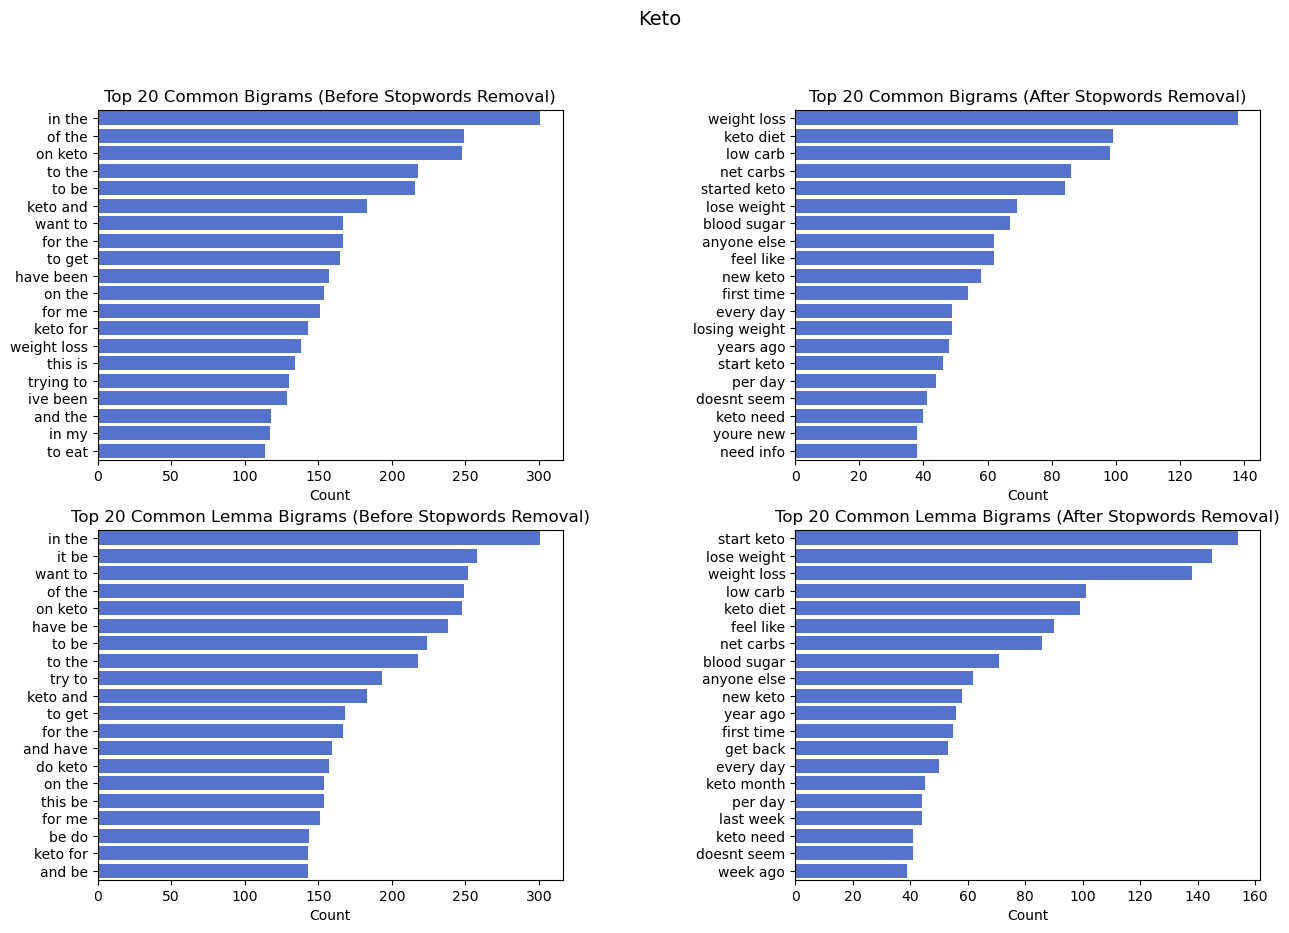

In [80]:
# plotting top bigrams for keto

df3clean = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_clean'], n=20, ngram=(2, 2), stop=None)
df3clean_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_clean'], n=20, ngram=(2, 2), stop=stopwords)
df3lemma = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_lemma'], n=20, ngram=(2, 2), stop=None)
df3lemma_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_lemma'], n=20, ngram=(2, 2), stop=stopwords)


# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top common words before removing stop words
sns.barplot(data=df3clean, y='text', x='count', color='royalblue', ax=axes[0,0])
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel('Count')
axes[0,0].set_title('Top 20 Common Bigrams (Before Stopwords Removal)')

# Plot the top common words after removing stop words
sns.barplot(data=df3clean_stop, y='text', x='count', color='royalblue', ax=axes[0,1])
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Count')
axes[0,1].set_title('Top 20 Common Bigrams (After Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df3lemma, y='text', x='count', color='royalblue', ax=axes[1,0])
axes[1,0].set_ylabel(None)
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Top 20 Common Lemma Bigrams (Before Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df3lemma_stop, y='text', x='count', color='royalblue', ax=axes[1,1])
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Count')
axes[1,1].set_title('Top 20 Common Lemma Bigrams (After Stopwords Removal)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.5)

# Add an overall title for all four plots
fig.suptitle('Keto', fontsize=14)

# Show the plot
plt.show()

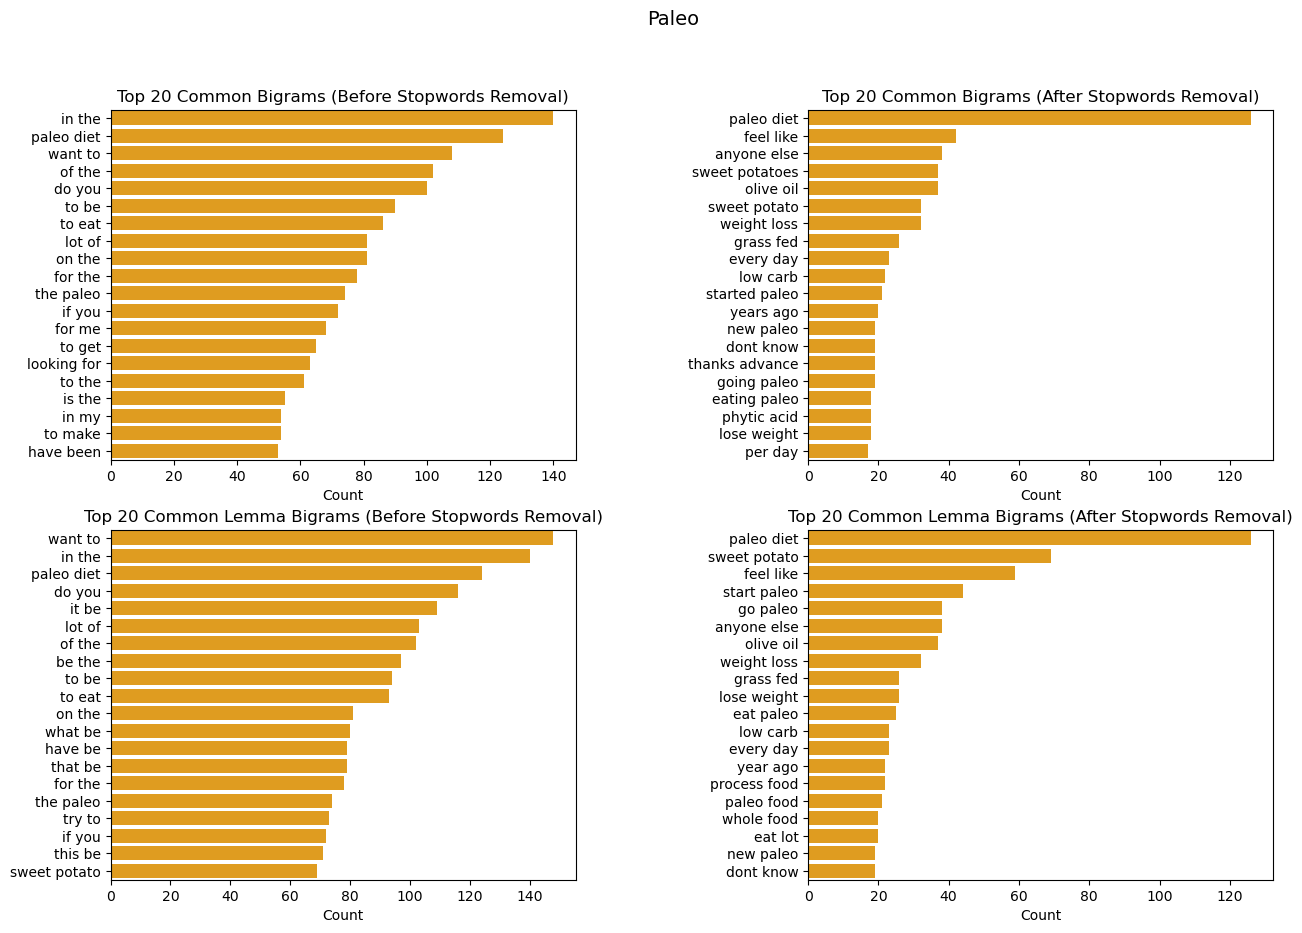

In [81]:
# plotting top bigrams for paleo

df4clean = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_clean'], n=20, ngram=(2, 2), stop=None)
df4clean_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_clean'], n=20, ngram=(2, 2), stop=stopwords)
df4lemma = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_lemma'], n=20, ngram=(2, 2), stop=None)
df4lemma_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_lemma'], n=20, ngram=(2, 2), stop=stopwords)


# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top common words before removing stop words
sns.barplot(data=df4clean, y='text', x='count', color='orange', ax=axes[0,0])
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel('Count')
axes[0,0].set_title('Top 20 Common Bigrams (Before Stopwords Removal)')

# Plot the top common words after removing stop words
sns.barplot(data=df4clean_stop, y='text', x='count', color='orange', ax=axes[0,1])
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Count')
axes[0,1].set_title('Top 20 Common Bigrams (After Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df4lemma, y='text', x='count', color='orange', ax=axes[1,0])
axes[1,0].set_ylabel(None)
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Top 20 Common Lemma Bigrams (Before Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df4lemma_stop, y='text', x='count', color='orange', ax=axes[1,1])
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Count')
axes[1,1].set_title('Top 20 Common Lemma Bigrams (After Stopwords Removal)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.5)

# Add an overall title for all four plots
fig.suptitle('Paleo', fontsize=14)

# Show the plot
plt.show()

#### Insights:
Bigrams was effective in helping us further understand the context of the unigrams. 
Based on the above plots, we observed that: 

#### Keto
- Keto users were mostly `new`, who just `started keto`, and were concerned with `losing weight`, even more so than the mention of `keto diet`. This seems to indicate that most of them `started keto` to `lose weight`. 
- Among the macronutrients, they were a lot more focused on `low carb` and `net carb`. This also explains the concern on `blood sugar`, since it is related to carb intake. 
- The time element was also contextualised further, with them indicating `every day`, `per day`, and possibly designating a `keto month`. 

#### Paleo
- The differences from keto were more distinct in bigram analysis. While there were no other terms more common than paleo diet itself, it further confirms our earlier assessment that paleo followers were more concerned about the type of food, than the nutrient itself. These include mentions of `sweet potato`, `olive oil`, `grass fed` (presumably referring to beef, which we will see in trigrams later), `process food`, `whole food`. We also did a search on these terms separately and found that foods such as sweet potato, olive oil and processed food have been controversial as a paleo-approved food or whole food. Grass fed, on the contrary, is popular as Paleo is big on grass-fed meat.$^1$
- Interestingly, the terms, `go paleo` and `eat paleo`, also suggest that paleo diet followers have a more philosophical approach, as it indicates an active decision to adopt a particular lifestyle, not just consume certain foods. 
- The term `paleo food` also suggests that they think about their diet in a holistic sense, extending beyond individual meals to their entire food landscape. 

<sup>
1. Sources: 
<br>sweet potatoes vs Paleo - <a href="https://thepaleodiet.com/are-sweet-potatoes-paleo">https://thepaleodiet.com/are-sweet-potatoes-paleo</a>
    <br>olive oil vs Paleo - <a href="https://www.aboutoliveoil.org/is-olive-oil-paleo">https://www.aboutoliveoil.org/is-olive-oil-paleo</a>
<br>processed food, whole food vs Paleo - <a href="https://www.healthline.com/nutrition/paleo-diet-meal-plan-and-menu">https://www.healthline.com/nutrition/paleo-diet-meal-plan-and-menu</a>
    <br>grass fed vs Paleo - <a href="https://paleoleap.com/importance-of-grass-fed-meat/">https://paleoleap.com/importance-of-grass-fed-meat/</a>
</sup>


### F. Trigrams

<a id='trigram'></a>

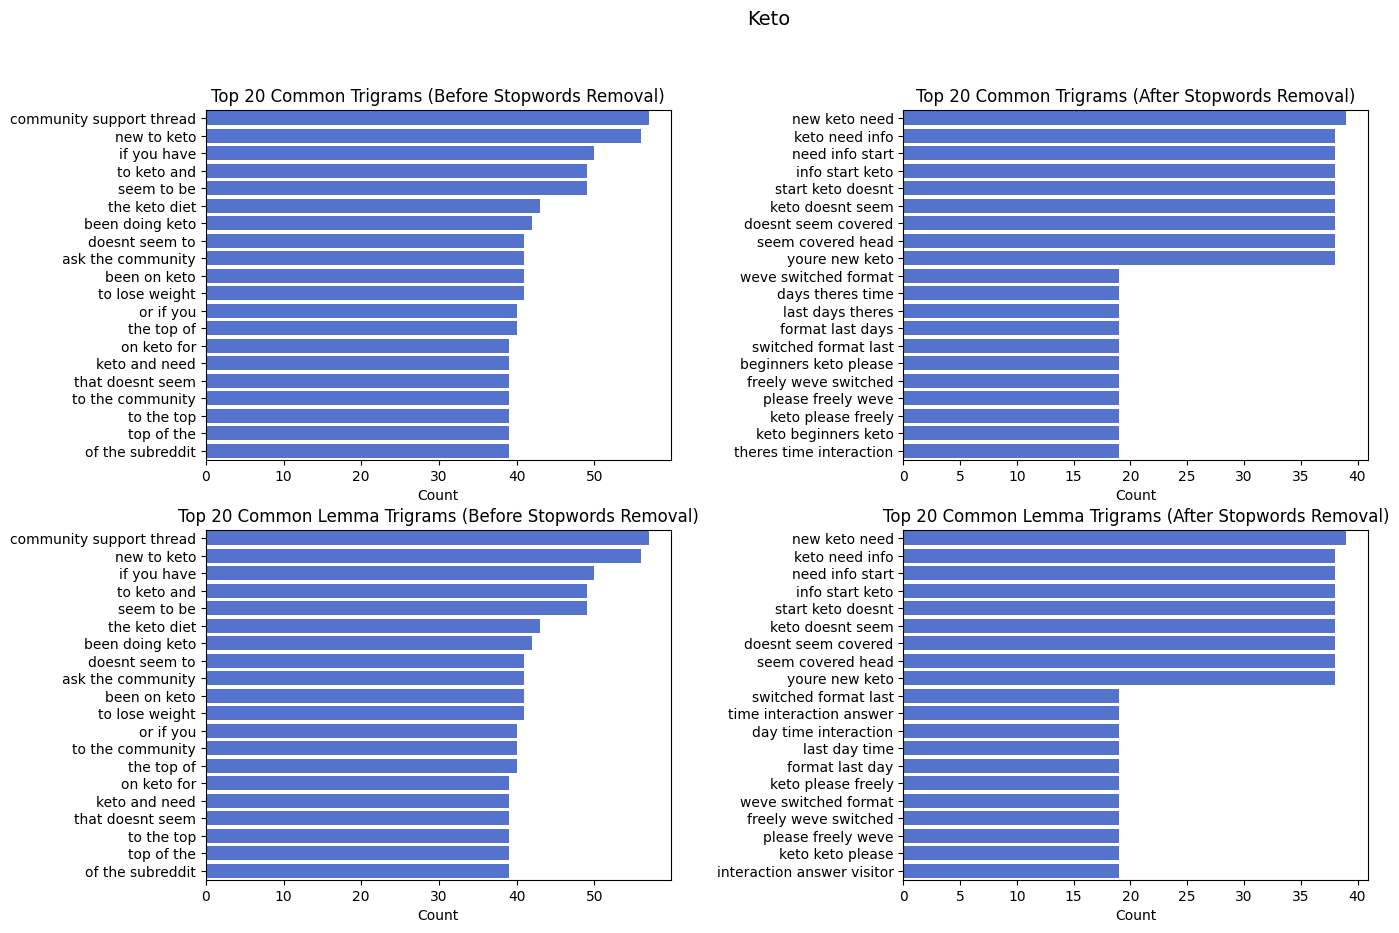

In [29]:
# plotting top trigrams for keto

df5clean = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_clean'], n=20, ngram=(3, 3), stop=None)
df5clean_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_clean'], n=20, ngram=(3, 3), stop=stopwords)
df5lemma = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_lemma'], n=20, ngram=(3, 3), stop=None)
df5lemma_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 0]['text_lemma'], n=20, ngram=(3, 3), stop=stopwords)


# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top common words before removing stop words
sns.barplot(data=df5clean, y='text', x='count', color='royalblue', ax=axes[0,0])
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel('Count')
axes[0,0].set_title('Top 20 Common Trigrams (Before Stopwords Removal)')

# Plot the top common words after removing stop words
sns.barplot(data=df5clean_stop, y='text', x='count', color='royalblue', ax=axes[0,1])
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Count')
axes[0,1].set_title('Top 20 Common Trigrams (After Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df5lemma, y='text', x='count', color='royalblue', ax=axes[1,0])
axes[1,0].set_ylabel(None)
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Top 20 Common Lemma Trigrams (Before Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df5lemma_stop, y='text', x='count', color='royalblue', ax=axes[1,1])
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Count')
axes[1,1].set_title('Top 20 Common Lemma Trigrams (After Stopwords Removal)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.5)

# Add an overall title for all four plots
fig.suptitle('Keto', fontsize=14)

# Show the plot
plt.show()

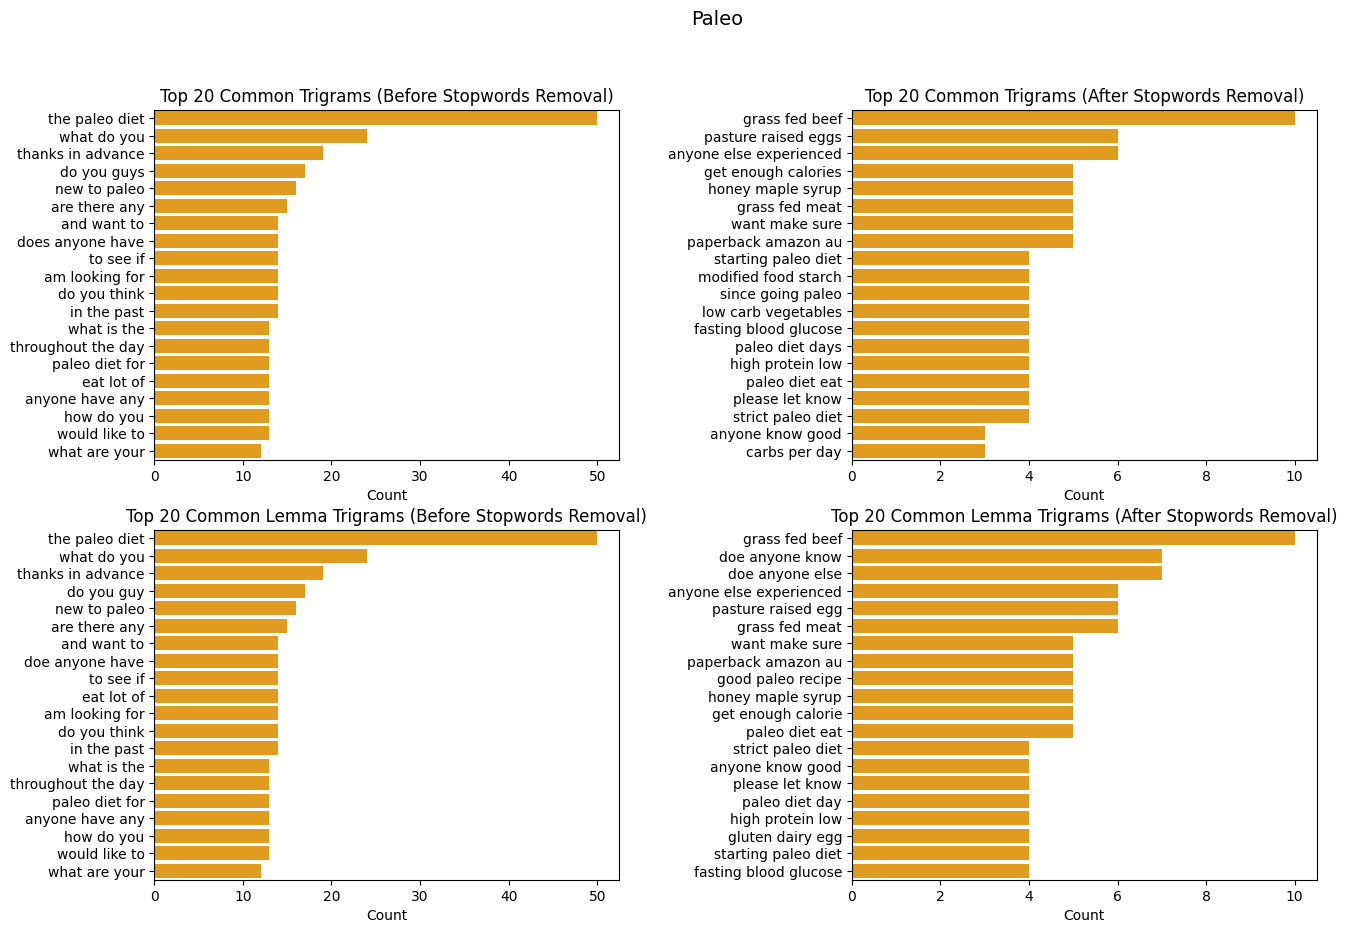

In [30]:
# plotting top trigrams for paleo

df6clean = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_clean'], n=20, ngram=(3, 3), stop=None)
df6clean_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_clean'], n=20, ngram=(3, 3), stop=stopwords)
df6lemma = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_lemma'], n=20, ngram=(3, 3), stop=None)
df6lemma_stop = top_n_grams(ketopaleo[ketopaleo['redditlabel'] == 1]['text_lemma'], n=20, ngram=(3, 3), stop=stopwords)


# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot the top common words before removing stop words
sns.barplot(data=df6clean, y='text', x='count', color='orange', ax=axes[0,0])
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel('Count')
axes[0,0].set_title('Top 20 Common Trigrams (Before Stopwords Removal)')

# Plot the top common words after removing stop words
sns.barplot(data=df6clean_stop, y='text', x='count', color='orange', ax=axes[0,1])
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Count')
axes[0,1].set_title('Top 20 Common Trigrams (After Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df6lemma, y='text', x='count', color='orange', ax=axes[1,0])
axes[1,0].set_ylabel(None)
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Top 20 Common Lemma Trigrams (Before Stopwords Removal)')

# Plot the top common lemma words after removing stop words
sns.barplot(data=df6lemma_stop, y='text', x='count', color='orange', ax=axes[1,1])
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Count')
axes[1,1].set_title('Top 20 Common Lemma Trigrams (After Stopwords Removal)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.5)

# Add an overall title for all four plots
fig.suptitle('Paleo', fontsize=14)

# Show the plot
plt.show()

#### Insights:

As for trigrams, there were no new insights for Keto. In fact, the top trigrams which are mainly related to `starting keto` and stating whether content was covered in the discussions, were less insightful as compared to the unigrams and bigrams. If anything, this further substantiates our earlier finding that keto subreddit was frequented by beginners, who needed to seek info and validation on their diet journey. 
On the contrary, Paleo's trigrams provided further insight - mainly to substantiate what we had previously assessed that it was more food related, where we now see even more types of food like `pasture raised eggs`, `honey maple syrup`, `modified food starch`, `low carb vegetables`, `gluten dairy egg`. There is also request to the community for a `good paleo recipe`, and concern to `get enough calories`. 

### G. Common Words

<a id='common'></a>

#### Comparing most common words across both subreddits

We also wanted to find out words common to both diets in the subreddits. To explore this, we did a venn diagram where we are able to visualise the common words in the intersection. Given that unigrams and bigrams produced sufficient insights, we will be drawing up a venn diagam based on these.

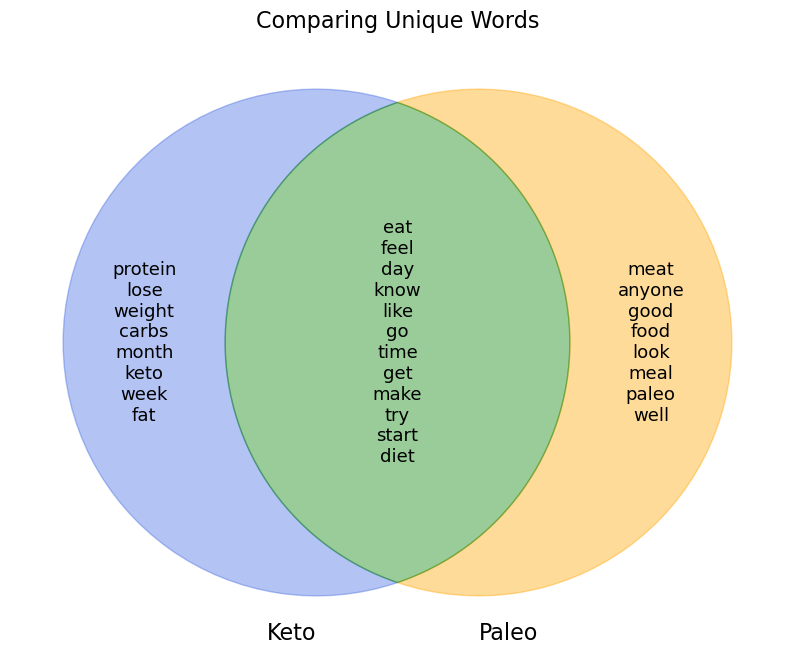

In [85]:
plt.figure(figsize=(10,10))
plt.title('Comparing Unique Words',fontsize=16)

set_a = set(df1lemma_stop['text'])
set_b = set(df2lemma_stop['text'])

venn = venn2([set_a,set_b],set_labels=['Keto','Paleo'])
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(16)
venn.get_label_by_id('B').set_size(16)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

venn.get_patch_by_id('10').set_color('royalblue')
venn.get_patch_by_id('01').set_color('orange')
venn.get_patch_by_id('11').set_color('green')
venn.get_patch_by_id('11').set_alpha(0.4)

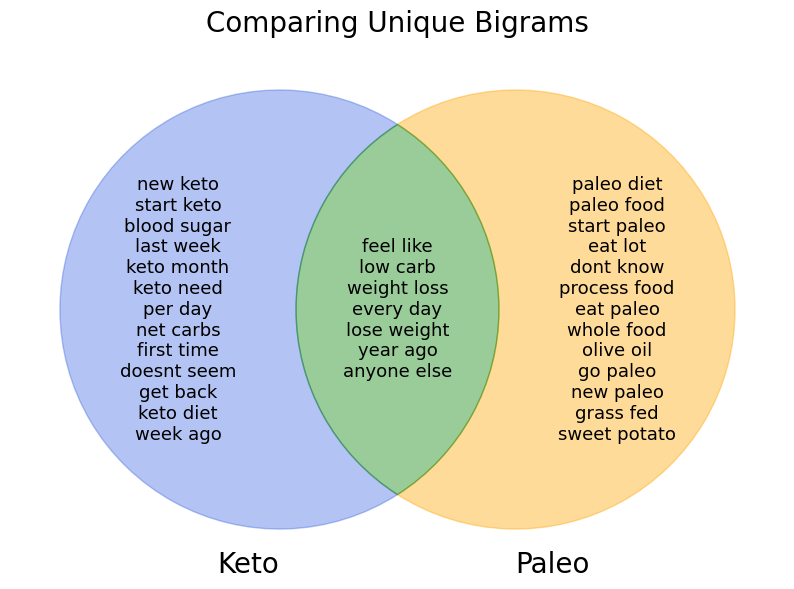

In [84]:
plt.figure(figsize=(10,10))
plt.title('Comparing Unique Bigrams',fontsize=20)

set_a = set(df3lemma_stop['text'])
set_b = set(df4lemma_stop['text'])

venn = venn2([set_a,set_b],set_labels=['Keto','Paleo'])
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

venn.get_patch_by_id('10').set_color('royalblue')
venn.get_patch_by_id('01').set_color('orange')
venn.get_patch_by_id('11').set_color('green')
venn.get_patch_by_id('11').set_alpha(0.4)

Looking at the common words and bigrams in both Keto and Paleo subreddits, both communities are definitely very keen about their day to day diets, and utilise the forum to elicit more opinions. `weight loss` and `low carb` are also key focus points for both groups.  

<b> End of Part II</b> <br>
[Part III](Part_3-Modelling.ipynb#part_ii)